# Import package

In [ ]:
!pip install mido

In [ ]:
import torch
import torch.utils.data as DataSet
import torch.nn as nn
import torch.optim as optim

from mido import MidiFile, MidiTrack, Message

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read MIDI file

Text(0.5, 1.0, 'Time')

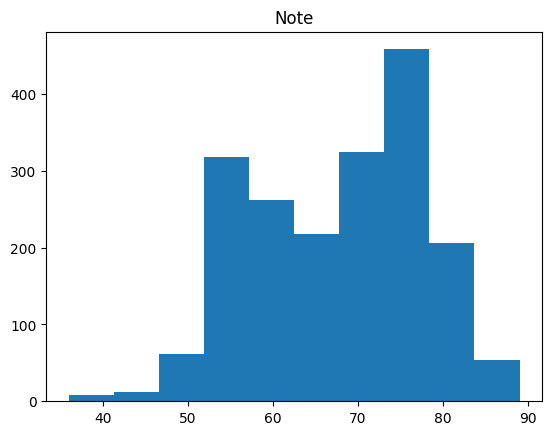

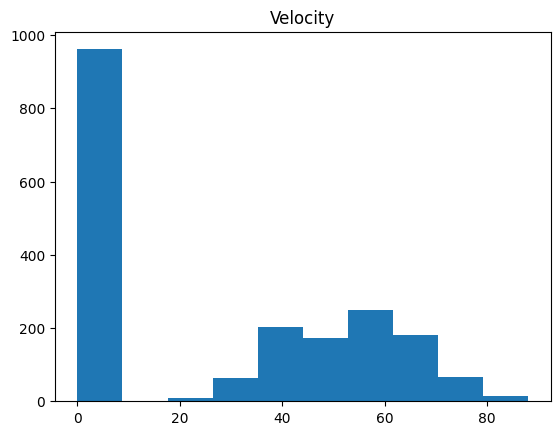

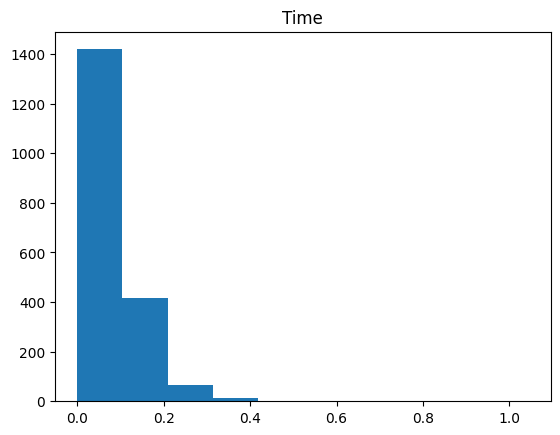

In [ ]:
# read the midi file
mid = MidiFile('./Sonata No. 16 C major  Rondo Allegretto.mid')

notes = []
time = float(0)
prev = float(0)

original = []

for msg in mid:
    time += msg.time

    if not msg.is_meta:
        if msg.channel == 0:
            if msg.type == 'note_on':
                # note[0] save pitch, note[1] save velocity, note[2] save time.
                note = msg.bytes()
                note = note[1:3]
                note.append(time - prev)
                prev = time
                notes.append(note)
                original.append([i for i in note])

plt.figure()
plt.hist([i[0] for i in notes])
plt.title('Note')
plt.figure()
plt.hist([i[1] for i in notes])
plt.title('Velocity')
plt.figure()
plt.hist([i[2] for i in notes])
plt.title('Time')

# Data preprocessing

In [ ]:
intervals = 10
values = np.array([i[2] for i in notes])
max_t = np.amax(values)
min_t = np.amin(values[values > 0])
interval = 1.0 * (max_t - min_t) / intervals

dataset = []
for note in notes:
    slot = np.zeros(229)

    # because note >= 24 and note <= 112, we first minus 24 to note.
    note[0] -= 24
    ind1 = note[0]
    # velocity >= 0 && velocity < 128
    ind2 = note[1]
    ind3 = int((note[2] - min_t) / interval + 1) if note[2] > 0 else 0
    slot[ind1] = 1
    slot[89 + ind2] = 1
    slot[89 + 128 + ind3] = 1
    dataset.append(slot)

In [ ]:
X = []
Y = []

n_prev = 10

for i in range(len(dataset) - n_prev):
    x = dataset[i:i+n_prev]
    y = notes[i+n_prev]
    ind3 = int((y[2] - min_t) / interval + 1) if y[2] > 0 else 0
    y[2] = ind3

    X.append(x)
    Y.append(y)

seed = dataset[0:n_prev]

idx = np.random.permutation(range(len(X)))
X = [X[i] for i in idx]
Y = [Y[i] for i in idx]

validX = X[: len(X) // 10]
X = X[len(X) // 10 :]
validY = Y[: len(Y) // 10]
Y = Y[len(Y) // 10 :]

batch_size = 16

train_ds = DataSet.TensorDataset(torch.FloatTensor(np.array(X, dtype = float)), torch.LongTensor(np.array(Y)))
train_loader = DataSet.DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers=4)

valid_ds = DataSet.TensorDataset(torch.FloatTensor(np.array(validX, dtype = float)), torch.LongTensor(np.array(validY)))
valid_loader = DataSet.DataLoader(valid_ds, batch_size = batch_size, shuffle = True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model

In [ ]:

class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first = True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, out_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden=None):
        hhh1 = hidden[0]
        output, hhh1 = self.lstm(input, hhh1)
        output = self.dropout(output)
        output = output[:, -1, ...]
        out = self.fc(output)

        x = self.softmax(out[:, :89])
        y = self.softmax(out[:, 89: 89 + 128])
        z = self.softmax(out[:, 89 + 128:])
        return (x,y,z)

    def initHidden(self, batch_size):
        out = []
        hidden1=torch.zeros(1, batch_size, self.hidden_size)
        cell1=torch.zeros(1, batch_size, self.hidden_size)
        out.append((hidden1, cell1))
        return out

# Define criterion and rightness

In [ ]:
def criterion(outputs, target):
    x, y, z = outputs
    loss_f = nn.NLLLoss()
    loss1 = loss_f(x, target[:, 0])
    loss2 = loss_f(y, target[:, 1])
    loss3 = loss_f(z, target[:, 2])
    return loss1 + loss2 + loss3

def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data).sum()
    return rights, len(labels)

# Train

In [ ]:
lstm = LSTMNetwork(229, 64, 229)
optimizer = optim.SGD(lstm.parameters(), lr=1e-1, momentum=0.9)
num_epochs = 100
train_losses = []
valid_losses = []
records = []

for epoch in range(num_epochs):
    train_loss = []
    for batch, data in enumerate(train_loader):
        lstm.train()
        init_hidden = lstm.initHidden(len(data[0]))
        optimizer.zero_grad()
        x, y = data[0].clone().detach().requires_grad_(True), data[1].clone().detach()
        outputs = lstm(x, init_hidden)
        loss = criterion(outputs, y)
        train_loss.append(loss.data.numpy())
        loss.backward()
        optimizer.step()

    valid_loss = []
    lstm.eval()
    rights = []
    for batch, data in enumerate(valid_loader):
        init_hidden = lstm.initHidden(len(data[0]))
        x, y = data[0].clone().detach().requires_grad_(True), data[1].clone().detach()
        outputs = lstm(x, init_hidden)
        loss = criterion(outputs, y)
        valid_loss.append(loss.data.numpy())
        right1 = rightness(outputs[0], y[:, 0])
        right2 = rightness(outputs[1], y[:, 1])
        right3 = rightness(outputs[2], y[:, 2])
        rights.append((right1[0] + right2[0] + right3[0]).numpy() * 1.0 / (right1[1] + right2[1] + right3[1]))

    print('Epoch{:>3d}/{:>3d}, trainingg loss:{:.2f}, validation loss:{:.2f}, accuracy:{:.2f}%'.format(epoch+1, num_epochs, np.mean(train_loss), np.mean(valid_loss), np.mean(rights)*100))
    records.append([np.mean(train_loss), np.mean(valid_loss), np.mean(rights)])

Epoch  1/100, trainingg loss:7.74, validation loss:7.29, accuracy:38.72%
Epoch  2/100, trainingg loss:6.85, validation loss:6.75, accuracy:40.68%
Epoch  3/100, trainingg loss:6.37, validation loss:6.35, accuracy:42.73%
Epoch  4/100, trainingg loss:5.83, validation loss:5.80, accuracy:49.42%
Epoch  5/100, trainingg loss:5.38, validation loss:5.52, accuracy:53.41%
Epoch  6/100, trainingg loss:4.95, validation loss:5.03, accuracy:55.47%
Epoch  7/100, trainingg loss:4.55, validation loss:4.72, accuracy:58.65%
Epoch  8/100, trainingg loss:4.27, validation loss:4.73, accuracy:58.63%
Epoch  9/100, trainingg loss:3.90, validation loss:4.41, accuracy:61.63%
Epoch 10/100, trainingg loss:3.69, validation loss:4.22, accuracy:62.99%
Epoch 11/100, trainingg loss:3.40, validation loss:4.18, accuracy:65.27%
Epoch 12/100, trainingg loss:3.15, validation loss:4.08, accuracy:65.76%
Epoch 13/100, trainingg loss:2.93, validation loss:3.95, accuracy:67.23%
Epoch 14/100, trainingg loss:2.75, validation loss:

# plot the loss and accuracy

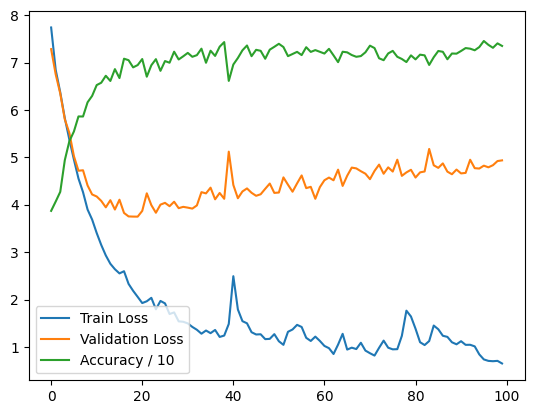

In [ ]:
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] * 10 for i in records]
plt.plot(a, '-', label = 'Train Loss')
plt.plot(b, '-', label = 'Validation Loss')
plt.plot(c, '-', label = 'Accuracy / 10')
plt.legend()

# create music

In [ ]:
predict_steps = 3000

x = seed
x = np.expand_dims(x, axis = 0)

lstm.eval()
initi = lstm.initHidden(1)
predictions = []
for i in range(predict_steps):
    xx = torch.tensor(np.array(x, dtype = float),dtype = torch.float, requires_grad = True)
    preds = lstm(xx, initi)
    a,b,c = preds

    ind1 = torch.multinomial(a.view(-1).exp(), num_samples = 1)
    ind2 = torch.multinomial(b.view(-1).exp(), num_samples = 1)
    ind3 = torch.multinomial(c.view(-1).exp(), num_samples = 1)

    ind1 = ind1.data.numpy()[0]
    ind2 = ind2.data.numpy()[0]
    ind3 = ind3.data.numpy()[0]

    note = [ind1 + 24, ind2, 0 if ind3 ==0 else ind3 * interval + min_t]
    predictions.append(note)

    slot = np.zeros(89 + 128 + 12, dtype = int)
    slot[ind1] = 1
    slot[89 + ind2] = 1
    slot[89 + 128 + ind3] = 1
    slot1 = np.expand_dims(slot, axis = 0)
    slot1 = np.expand_dims(slot1, axis = 0)

    x = np.concatenate((x, slot1), 1)
    x = x[:, 1:, :]

# load creat music to midi file

In [ ]:
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

for i, note in enumerate(predictions):
    note = np.insert(note, 0, 147)
    bytes = note.astype(int)
    msg = Message.from_bytes(bytes[0:3])
    time = int(note[3]/0.001025)
    msg.time = time
    track.append(msg)

mid.save('./new_song.mid')